In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import os
dir = '/Users/signapoop/Desktop/autotune'
os.chdir(dir)
from autotune.core.HyperbandOptimiser import HyperbandOptimiser
from autotune.core.RandomOptimiser import RandomOptimiser
from autotune.core.TpeOptimiser import TpeOptimiser
from autotune.core.SigOptimiser import SigOptimiser

In [11]:
def plot_convergence(optimisers, problem_text=""):
    fig, ax = plt.subplots(1, 1, figsize=(9, 7), dpi=200)
    lines = ['--bs', '--kd', '--ro', '--gx']
    for i, optimiser in enumerate(optimisers):
        ax.plot(optimiser.checkpoints, optimiser.Y_best, lines[i], label=optimiser.name)
    
    ax.set_ylim(0.125,0.32)
    #ax.set_ylim(0.05,0.10)
    ax.grid()
    plt.ylabel('Min Test Error')
    plt.xlabel('Time (s)')
    plt.legend()
    
    res = ["{} min error = {:.4f}".format(opt.name, min(opt.Y)) for opt in optimisers]
    title = problem_text + "\n" + "\n".join(res)
    plt.title(title)
    plt.savefig(path+"/"+problem_text, dpi=200)
    plt.show()

In [12]:
problem_text = "cifar_5hps_1"
#problem_text = "tpe_test"
path = '/Users/signapoop/Desktop/results/' + problem_text
os.chdir(path)
file = open("results.pkl",'rb')
object_file = pickle.load(file)
file.close()

# Unpack file
hyper_opt = object_file[0]
random_opt = object_file[1]
tpe_opt = object_file[2]

In [13]:
file = open("results_sigopt.pkl",'rb')
object_file_2 = pickle.load(file)
file.close()
sig_opt = object_file_2[0]

In [14]:
file = open("tpe_10_results.pkl",'rb')
object_file_2 = pickle.load(file)
file.close()
tpe_opt = object_file_2[0]

IOError: [Errno 2] No such file or directory: 'tpe_10_results.pkl'

In [12]:
# filename = '/Users/signapoop/Desktop/' + 'random_results.pkl'
# with open(filename, 'wb') as f:
#     pickle.dump([random_opt], f)

In [15]:
optimisers = [hyper_opt, random_opt, tpe_opt, sig_opt]

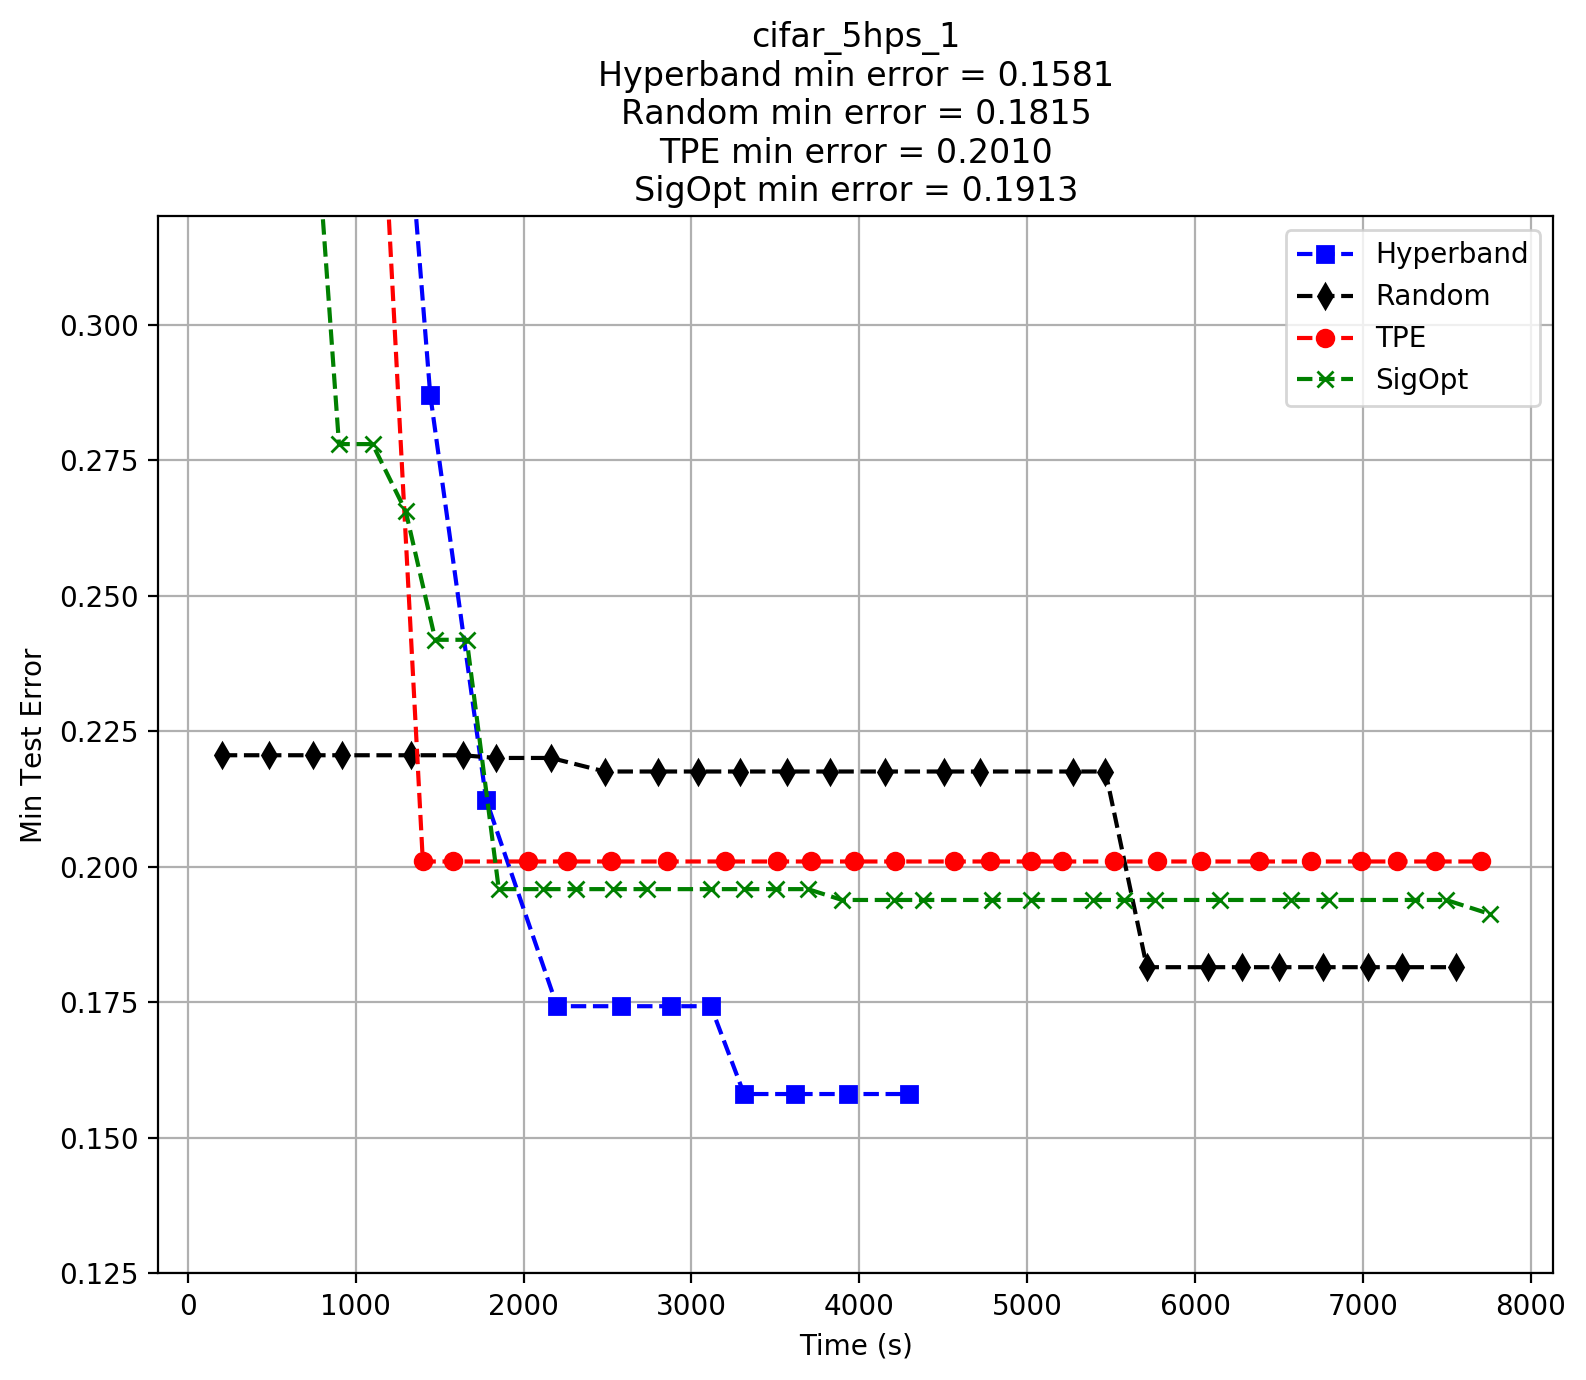

In [16]:
# Plot convergence
plot_convergence(optimisers, problem_text)

## Parallel Coordinates

In [16]:
dir = '/Users/signapoop/Desktop/autotune'
os.chdir(dir)
#from autotune.benchmarks.mnist_problem import MnistProblem
from autotune.benchmarks.cifar_problem import CifarProblem
input_dir = '/Users/signapoop/Desktop/data/'
output_dir = '/Users/signapoop/Desktop/autotune/autotune/experiments/checkpoint/'
problem = CifarProblem(input_dir, output_dir)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using GPUs? : False


In [24]:
hps = problem.domain.keys()
arms = {}
for hp in hps:
    #arms[hp] = [arm[hp] for arm in hyper_opt.arms]
    arms[hp] = [arm[hp] for arm in hyper_opt.arms] + [arm[hp] for arm in random_opt.arms] 
print(hps)

['lr_step', 'gamma', 'momentum', 'n_units_2', 'n_units_3', 'n_units_1', 'learning_rate', 'weight_decay', 'batch_size']


In [25]:
if 'n_resources' in hps:
    hps.remove('n_resources')

In [26]:
ranges = {}
for hp in hps:
    ranges[hp] = [problem.domain[hp].get_min(), problem.domain[hp].get_max()]
print(ranges)

{'n_units_2': [2.7725887222397811, 5.5451774444795623], 'n_units_3': [2.7725887222397811, 5.5451774444795623], 'n_units_1': [2.7725887222397811, 5.5451774444795623], 'learning_rate': [-13.815510557964274, 0.0], 'batch_size': [32, 512], 'lr_step': [1, 5], 'gamma': [-6.9077552789821368, -2.3025850929940455], 'weight_decay': [-13.815510557964274, -2.3025850929940455], 'momentum': [0.3, 0.999]}


In [27]:
# Handle params on log scale
labels = {}
for hp in hps:
    labels[hp] = hp
    if problem.domain[hp].scale == 'log':
        arms[hp] = np.log(arms[hp]) / np.log(problem.domain[hp].logbase)
        labels[hp] = labels[hp] + '_log'

In [29]:
print(len(hyper_opt.Y + random_opt.Y))

39


In [37]:
# Plot parallel coordinates with plotly
import plotly.plotly as py
import plotly.graph_objs as go

color = hyper_opt.Y + random_opt.Y

data = [
    go.Parcoords(
        line = dict(color = color[:15],
                    #colorscale = [[0,'#D7C16B'],[0.5,'#23D8C3'],[1,'#F3F10F']],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 1),
        dimensions = [
            dict(range = ranges[hp],
                 label = labels[hp], values = arms[hp][:15]) for hp in hps
        ]
    )
]

py.iplot(data, filename = 'parcoords-advanced', image='png', width=250)